# **Dataset Exploratory Analysis**

Nous avons décidé d'analyser les cancers du sein afin de détecter d'éventuels patterns pour les identifier précocement. Notre variable cible est le degré de malignité.

In [5]:
pip install openml

Nous préparons toutes les librairies que nous allons utiliser.

In [ ]:
import numpy as np
import pandas as pd
import openml
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## **Metadata Overview**


In [ ]:
dataset_id = 77
dataset = openml.datasets.get_dataset(dataset_id)
csv_filename = "dataset_breast_cancer.csv"
X, y, _, _ = dataset.get_data(dataset_format="dataframe")
df = pd.concat([X, y], axis=1)
df.to_csv(csv_filename, index=False)



cancer_breast = pd.read_csv('dataset_breast_cancer.csv')
cancer_breast.head()
cancer_breast.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   age          1000000 non-null  object
 1   menopause    1000000 non-null  object
 2   tumor-size   1000000 non-null  object
 3   inv-nodes    1000000 non-null  object
 4   node-caps    1000000 non-null  object
 5   deg-malig    1000000 non-null  int64 
 6   breast       1000000 non-null  object
 7   breast-quad  1000000 non-null  object
 8   irradiat     1000000 non-null  object
 9   Class        1000000 non-null  object
dtypes: int64(1), object(9)
memory usage: 76.3+ MB


In [ ]:
nb_instances = cancer_breast.shape[0]
nb_features = cancer_breast.shape[1]
feature_types = cancer_breast.dtypes

print("Nombre d'instances : ", nb_instances)
print("Nombre de features : ", nb_features)
print(feature_types.value_counts())


Nombre d'instances :  1000000
Nombre de features :  10
object    9
int64     1
Name: count, dtype: int64


Nous avons bien 10 features dont une seule qui est un int. Plus tard, nous allons transformer les autres en int pour pouvoir travailler dessus.

## **Handling Missing Values**


In [7]:
nb_nulls = cancer_breast.isnull().sum()
total_nulls = cancer_breast.isnull().sum().sum()

print("Nombre de valeurs nulles par colonne :")
print(nb_nulls)
print(f"Total des valeurs nulles : {total_nulls}")

Nombre de valeurs nulles par colonne :
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64
Total des valeurs nulles : 0


Sachant qu'aucune donnée n'est manquante dans notre dataset, nous pouvons continuer notre exploration.

## **Feature Distribution and Outliers**


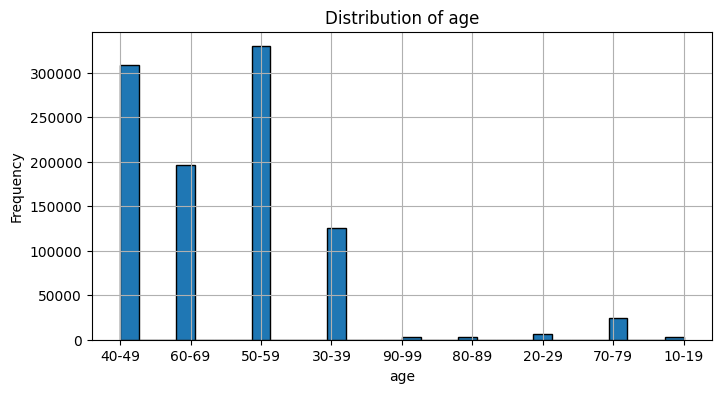

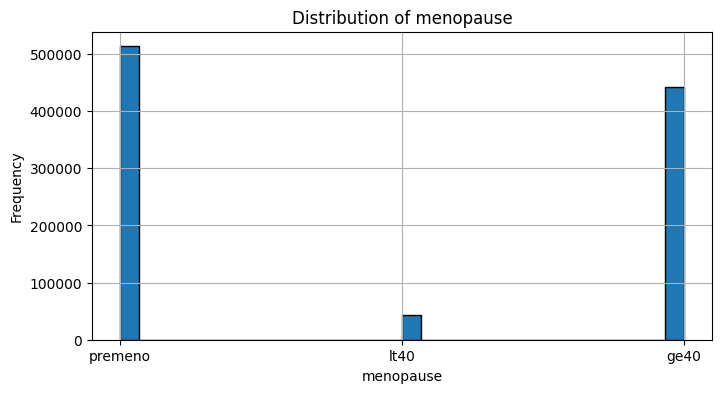

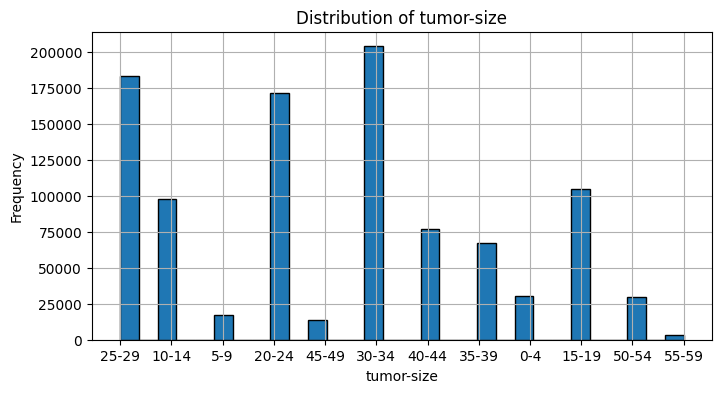

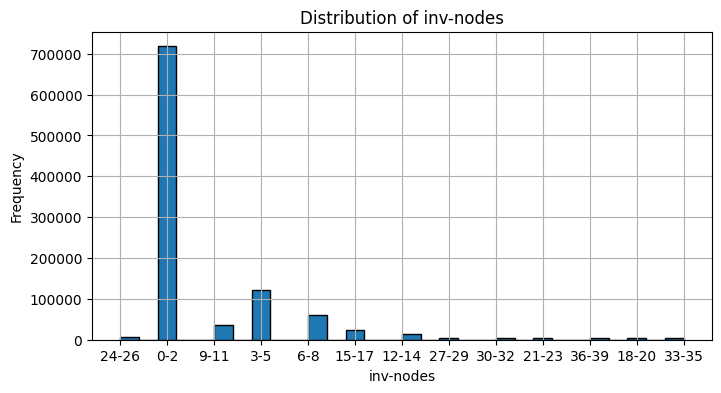

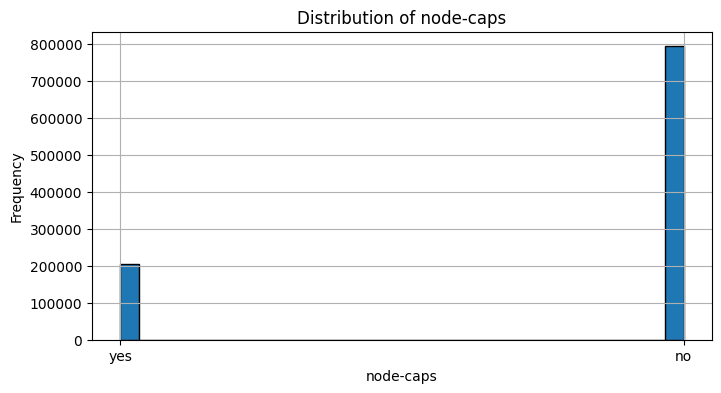

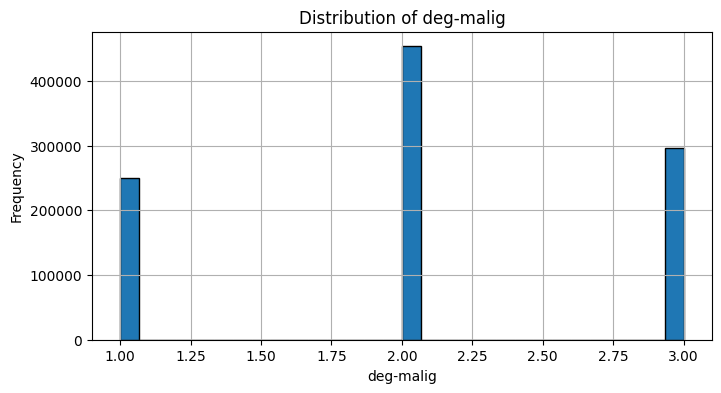

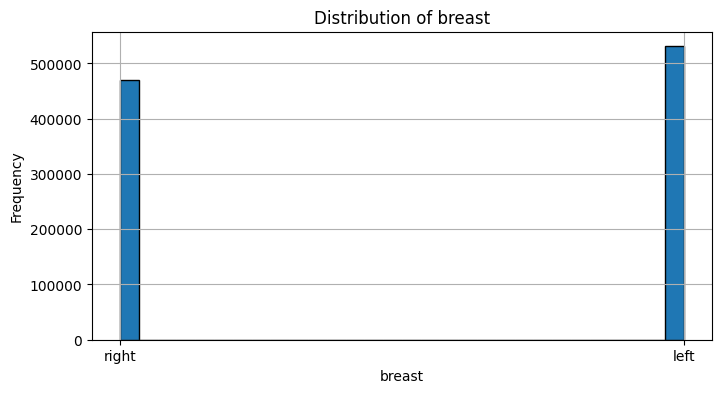

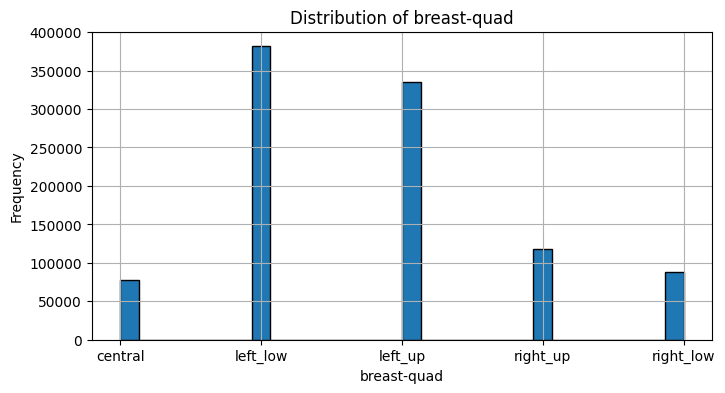

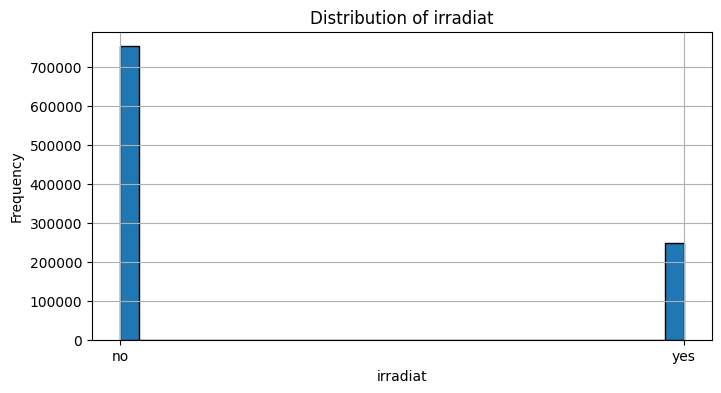

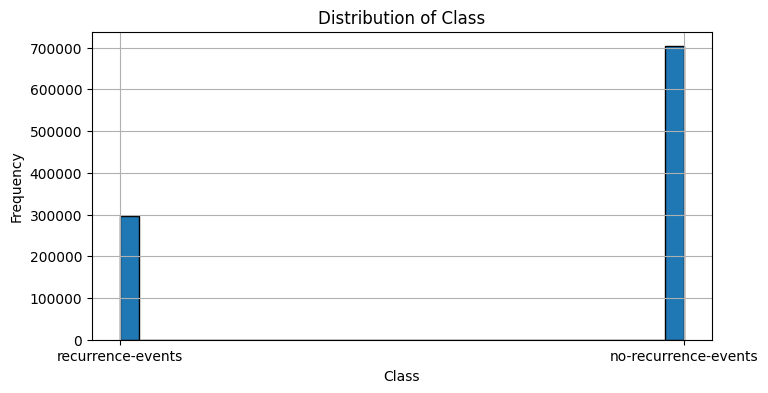

In [8]:
for column in cancer_breast.select_dtypes(include=['object', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    cancer_breast[column].hist(bins=30, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Nous souhaitons travailler sur le degrès de malignité et de récurrence d'un cancer. Ce dernier est en type String donc nous devons le changer en int. Pour se faire nous allons utiliser la fonction get_dummies.

Nous faisons en sorte que toutes les features soient en numérique pour pouvoir les traiter plus facilement

In [9]:
cancer_breast['Class']=cancer_breast['Class'].replace({'no-recurrence-events':0, 'recurrence-events':1})
cancer_breast['menopause']=cancer_breast['menopause'].replace({'premeno':0, 'lt40':1, 'ge40':2})
cancer_breast['inv-nodes']=cancer_breast['inv-nodes'].replace({'0-2':0,'3-5':3,'6-8':6,'9-11':9,'12-14':12,'15-17':15,'18-20':18,'21-23':21,'24-26':24,'27-29':27,'30-32':30,'33-35':33,'36-39':36})
cancer_breast['node-caps']=cancer_breast['node-caps'].replace({'no':0, 'yes':1})
cancer_breast['breast']=cancer_breast['breast'].replace({'left':0, 'right':1})
cancer_breast['irradiat']=cancer_breast['irradiat'].replace({'no':0, 'yes':1})
cancer_breast['irradiat']=cancer_breast['irradiat'].replace({'no':0, 'yes':1})
cancer_breast['age'] = cancer_breast['age'].str.split('-').str[0].astype(int)
cancer_breast['tumor-size'] = cancer_breast['tumor-size'].str.split('-').str[0].astype(int)

print(cancer_breast.head())

<ipython-input-9-435ffa1c768f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cancer_breast['Class']=cancer_breast['Class'].replace({'no-recurrence-events':0, 'recurrence-events':1})
<ipython-input-9-435ffa1c768f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cancer_breast['menopause']=cancer_breast['menopause'].replace({'premeno':0, 'lt40':1, 'ge40':2})
<ipython-input-9-435ffa1c768f>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicit

   age  menopause  tumor-size  inv-nodes  node-caps  deg-malig  breast  \
0   40          0          25         24          1          3       1   
1   40          0          25          0          0          2       0   
2   60          1          25          0          0          2       1   
3   40          2          10          0          0          3       0   
4   40          0           5          0          0          1       1   

  breast-quad  irradiat  Class  
0     central         0      1  
1    left_low         0      0  
2    left_low         0      0  
3    left_low         0      0  
4     central         0      0  


## **Target Feature Analysis**


In [10]:
target_name = 'deg-malig'
data, target = cancer_breast.drop(columns=target_name), cancer_breast[target_name]

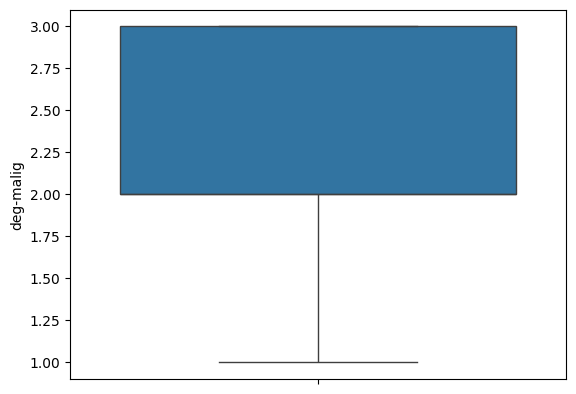

In [11]:
sns.boxplot(target)
plt.show()

Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

target= np.where(target < lower_limit, lower_limit, target)
target= np.where(target > upper_limit, upper_limit, target)


La colonne 'age' est de type String. Nous désirons travailler dessus et nous l'avons changé pour prendre en compte l'âge des patients.
Ainsi, la catégorie en 10 et 19 ans devient 10 ans, et ainsi de suite.


age
50    329377
40    308885
60    196058
30    124910
70     23958
20      6746
80      3408
10      3374
90      3284
Name: count, dtype: int64


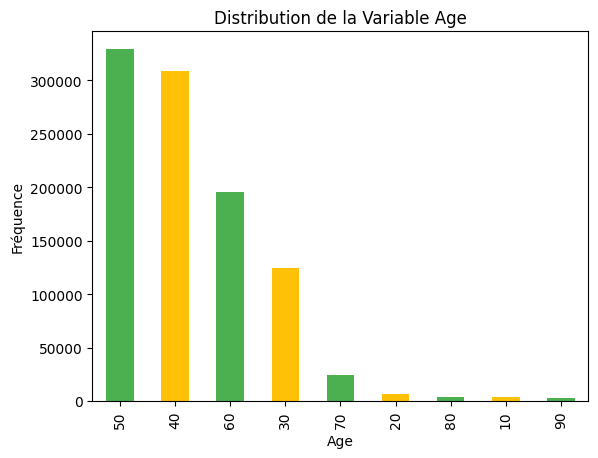

age
50    0.329377
40    0.308885
60    0.196058
30    0.124910
70    0.023958
20    0.006746
80    0.003408
10    0.003374
90    0.003284
Name: proportion, dtype: float64


In [12]:
data_age = pd.DataFrame({'age': data['age']})

target_counts = data_age['age'].value_counts()

print(target_counts)

target_counts.plot(kind='bar', color=['#4CAF50', '#FFC107'])
plt.title('Distribution de la Variable Age')
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.show()

class_proportions = data['age'].value_counts(normalize=True)

print(class_proportions)


Nous pouvons observer que la fréquence d'apparition d'un cancer selon l'âge
est inégalement réparti.
Les plus hauts pourcentages sont chez les personnes ayant entre 40 et 50 ans.

Nous allons voir comment sont distribuées les features que nous souhaitons analyser.

## **Feature Correlation and Selection**


               Class  menopause  inv-nodes  node-caps    breast  irradiat  \
Class       1.000000  -0.050246   0.226334   0.261794 -0.057931  0.190184   
menopause  -0.050246   1.000000  -0.012216  -0.015226  0.002750 -0.011186   
inv-nodes   0.226334  -0.012216   1.000000   0.440238 -0.013356  0.264025   
node-caps   0.261794  -0.015226   0.440238   1.000000 -0.016379  0.295931   
breast     -0.057931   0.002750  -0.013356  -0.016379  1.000000 -0.011957   
irradiat    0.190184  -0.011186   0.264025   0.295931 -0.011957  1.000000   
age        -0.060091   0.620075  -0.014328  -0.017067  0.002483 -0.013629   
tumor-size  0.163631  -0.008644   0.036255   0.044043 -0.009523  0.030382   

                 age  tumor-size  
Class      -0.060091    0.163631  
menopause   0.620075   -0.008644  
inv-nodes  -0.014328    0.036255  
node-caps  -0.017067    0.044043  
breast      0.002483   -0.009523  
irradiat   -0.013629    0.030382  
age         1.000000   -0.010149  
tumor-size -0.010149    1.

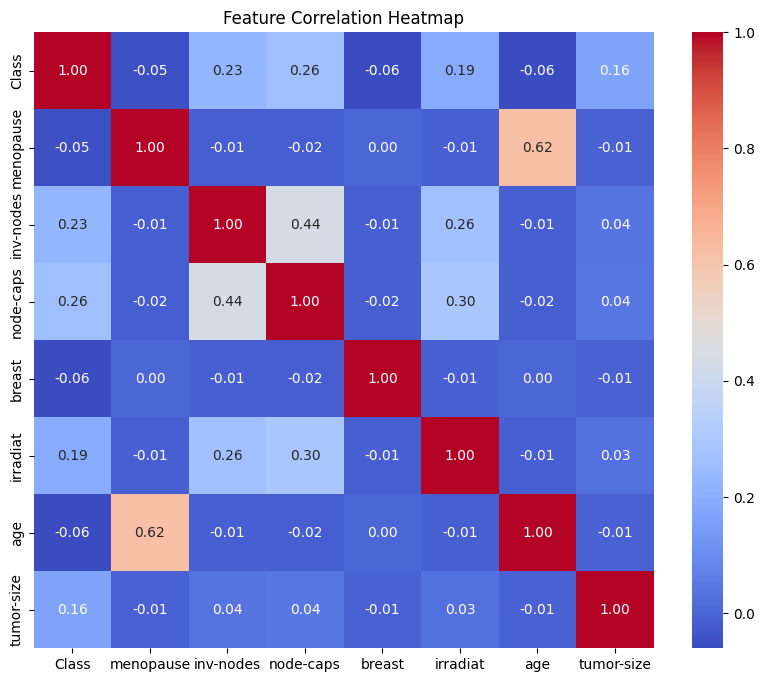

In [13]:
numerical_features = ['Class','menopause',
'inv-nodes',
'node-caps',
'breast',
'irradiat',
'age',
'tumor-size']

correlation_matrix = cancer_breast[numerical_features].corr()

# Display correlation matrix
print(correlation_matrix)

# Optional: Visualize correlation as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

La ménopause et l'age sont corrélés. Nous pouvons supprimer la ménopause pour éviter une colinéarité.

Inv-nodes et node-caps peuvent être de bonnes features de traitement.

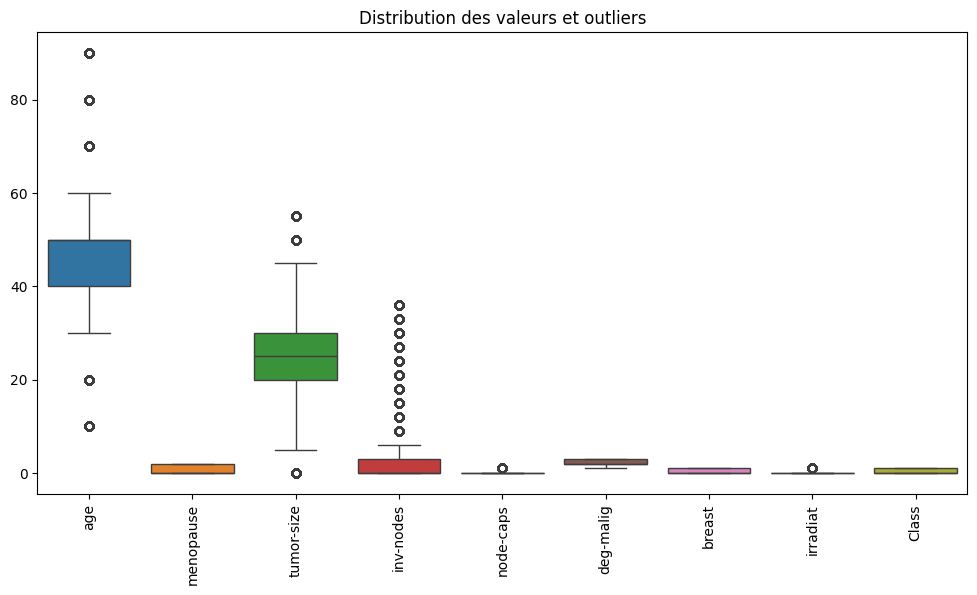

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cancer_breast.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.title("Distribution des valeurs et outliers")
plt.show()

In [16]:
sns.countplot(x=cancer_breast['target'])
plt.title("Répartition de la variable cible")
plt.show()

KeyError: 'target'

# **ML Baseline & Ensemble Models**


In [17]:
cancer_breast['breast-quad']=cancer_breast['breast-quad'].replace({'central':0,'left_low':1,'left_up':2,'right_low':3,'right_up':4})
data['breast-quad']=data['breast-quad'].replace({'central':0,'left_low':1,'left_up':2,'right_low':3,'right_up':4})


<ipython-input-17-7c13bd80ae26>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cancer_breast['breast-quad']=cancer_breast['breast-quad'].replace({'central':0,'left_low':1,'left_up':2,'right_low':3,'right_up':4})
<ipython-input-17-7c13bd80ae26>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['breast-quad']=data['breast-quad'].replace({'central':0,'left_low':1,'left_up':2,'right_low':3,'right_up':4})


{'fit_time': array([0.36243057, 0.32495332, 0.29635477, 0.25718093, 0.23189807,
       0.25103354, 0.23918939, 0.22373438, 0.22403717, 0.22866321]), 'score_time': array([0.01091599, 0.02156591, 0.02035284, 0.0093987 , 0.00944924,
       0.01078534, 0.00898361, 0.0093646 , 0.00862813, 0.00942349]), 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pip

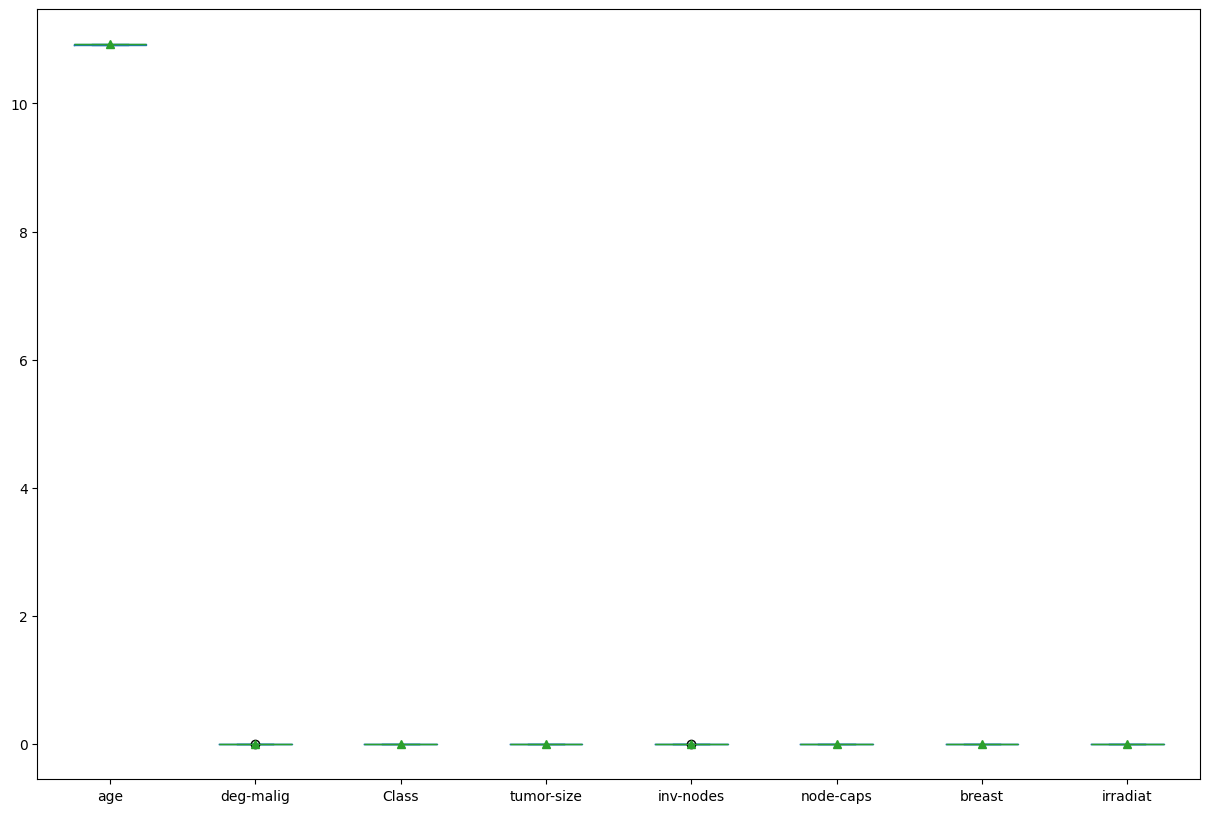

In [18]:
features = ['age', 'deg-malig', 'Class','tumor-size','inv-nodes','node-caps','breast','irradiat']
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
age_target = data['age']
data2 = data.drop(columns=['menopause'])
cv_results = cross_validate(pipeline, data2, age_target, cv=10, return_estimator=True)
print(cv_results)

[max(est[-1].coef_) for est in cv_results['estimator']]


coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = pd.DataFrame(coefs, columns=features)
coefs.describe().loc[["min", "max"]]

_, ax = plt.subplots(figsize=(15, 10))

boxplot_property = {'vert': True, 'patch_artist': False, 'showmeans': True}
_ = coefs.plot.box(**boxplot_property, ax=ax)

Nous avons essayé de réaliser une régression sur les trois features qui nous intéressent. N'ayant pas pu continuer, nous préférons utiliser un Precision and Recall entre l'âge et le fait d'une rechute du patient.

In [19]:
data_numerical = data[numerical_features]

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

pipeline.fit(data_numerical, target)
cv_results = cross_validate(pipeline, data_numerical, target, cv=10, scoring='accuracy')

mean_accuracy = cv_results['test_score'].mean()

print(mean_accuracy)

categorical_features = list(set(data.columns) - set(numerical_features) - set([target_name]))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline_full = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cv_results_full = cross_validate(pipeline_full, data, target, cv=10, scoring='accuracy')


print(f"Full accuracy: {cv_results_full['test_score'].mean()}, Full accuracy : {cv_results['test_score'].mean()}")

0.510715
Full accuracy: 0.510715, Full accuracy : 0.510715


La target 'Class' qui montre la malignité montre avec l'accuracy que c'est assez aléatoire.


## **Splitting the Dataset**


In [20]:
np.random.seed(42)
data_test = pd.DataFrame({
    'age': np.random.randint(20, 80, 100000),
    'deg-malig': np.random.choice([1,2,3]),
    'tumor-size'  : np.random.randint(20, 100, 100000),
    'Class': np.random.choice([0, 1], size=100000, p=[0.7, 0.3]),
    'node-caps': np.random.choice([0, 1], size=100000, p=[0.7, 0.3]),
    'inv-nodes': np.random.randint(20, 100, 100000),
})

X = data_test.drop(columns=['Class'])
y = data_test['Class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Entraînement: {len(X_train)} échantillons")
print(f"Validation: {len(X_val)} échantillons")
print(f"Test: {len(X_test)} échantillons")


Entraînement: 60000 échantillons
Validation: 20000 échantillons
Test: 20000 échantillons


Avec les données de test, nous retrouvons la même chose que sur les données originales. Seule, chaque catégorie n'est pas suffisante.

## **Model Selection & Justification**


Avec les données de test et de validation, nous trouvons un score d'acquité assez élevé de 75%
Ensemble, nous pouvons considérer que les features choisies sont intéressantes. Mais, il peut être intéressant d'utiliser d'autres métriques.


In [21]:
def train_cancer_models(X, y, cv=5):
    """
    Simple function to train and evaluate models on breast cancer data using cross-validation

    Parameters:
    X: features DataFrame
    y: target Series
    cv: number of folds for cross-validation (default=5)
    """

    feature_names = X.columns

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv)

        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_acc = accuracy_score(y_val, val_pred)

        results[name] = {
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'val_acc': val_acc
        }

        print(f'\n{name} Results:')
        print(f'Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
        print(f'Validation accuracy: {val_acc:.4f}')
        print('\nClassification Report:')
        print(classification_report(y_val, val_pred))

        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)

            sns.barplot(data=feature_imp, x='Importance', y='Feature')
            plt.title(f'Feature Importance - {name}')
            plt.tight_layout()
            plt.show()

    best_model_name = max(results, key=lambda k: results[k]['cv_mean'])
    best_model = models[best_model_name]

    print(f'\nBest Model: {best_model_name}')
    print(f'Best Cross-validation accuracy: {results[best_model_name]["cv_mean"]:.4f}')
    print(f'Best Validation accuracy: {results[best_model_name]["val_acc"]:.4f}')

    return best_model, scaler, results


Random Forest Results:
Cross-validation accuracy: 0.5025 (+/- 0.0008)
Validation accuracy: 0.5059

Classification Report:
              precision    recall  f1-score   support

         1.0       0.32      0.02      0.04     49750
         2.0       0.50      0.80      0.61     90853
         3.0       0.54      0.46      0.50     59397

    accuracy                           0.51    200000
   macro avg       0.45      0.43      0.38    200000
weighted avg       0.47      0.51      0.44    200000



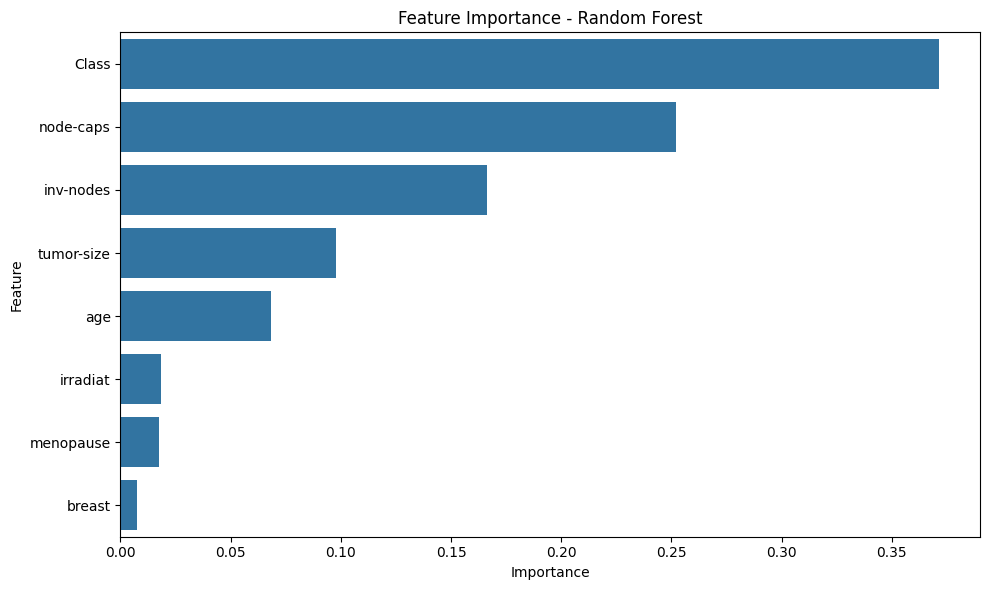


Gradient Boosting Results:
Cross-validation accuracy: 0.5101 (+/- 0.0008)
Validation accuracy: 0.5131

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00     49750
         2.0       0.51      0.79      0.62     90853
         3.0       0.53      0.52      0.53     59397

    accuracy                           0.51    200000
   macro avg       0.34      0.44      0.38    200000
weighted avg       0.39      0.51      0.44    200000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


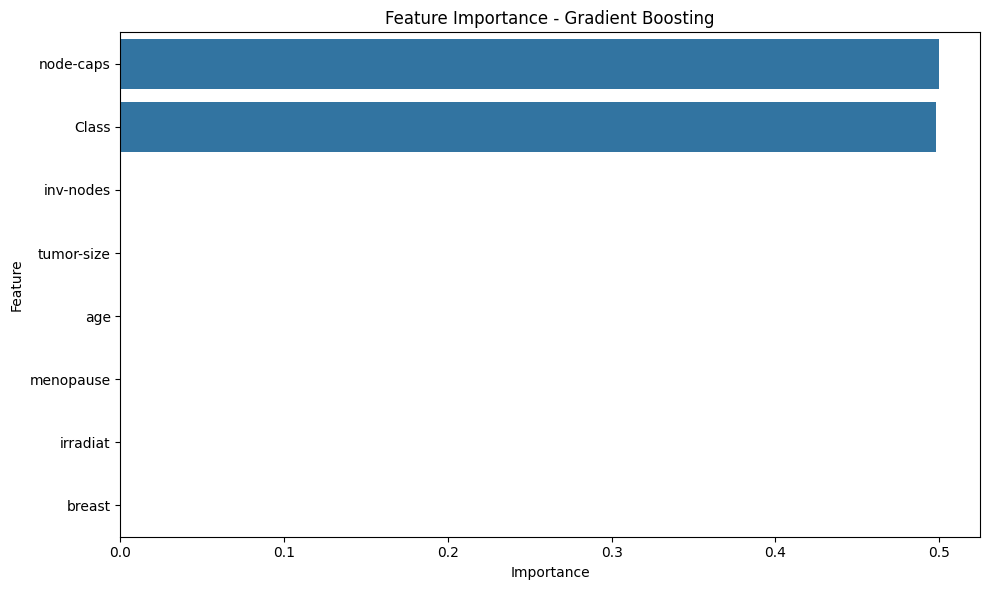


Best Model: Gradient Boosting
Best Cross-validation accuracy: 0.5101
Best Validation accuracy: 0.5131


(GradientBoostingClassifier(random_state=42),
 StandardScaler(),
 {'Random Forest': {'cv_mean': 0.5025175,
   'cv_std': 0.0003930927053507755,
   'val_acc': 0.50594},
  'Gradient Boosting': {'cv_mean': 0.51009125,
   'cv_std': 0.00038423218891702864,
   'val_acc': 0.513065}})

In [22]:
train_cancer_models(cancer_breast[numerical_features], target)

Le modèle semble assez stable et n'est pas surentrainé. Mais, une précision autour de 50% suggère que le modèle ne performe pas bien et pourrait être à peine meilleur qu’un choix aléatoire.
Ainsi, le modèle semble un peu biaisé au vu de la classe 2. Il faudra revérifier les paramètres.

## **Hyperparameter Tuning & Improvements**


In [ ]:
def prepare_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=0.2, random_state=42
  )

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled, y_train, y_test, scaler

class BaseModel:
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

class StudentNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StudentNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.softmax(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def distill_knowledge(teacher_model, X_train, y_train, input_size, hidden_size, output_size):
    student_model = StudentNN(input_size, hidden_size, output_size)

    soft_targets = teacher_model.predict_proba(X_train)

    dataset = CustomDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters())

    student_model.train()
    for epoch in range(10):
        for batch_X, _ in dataloader:
            batch_soft_targets = torch.FloatTensor(
                teacher_model.predict_proba(batch_X.numpy())
            )

            student_outputs = student_model(batch_X)

            loss = criterion(student_outputs, batch_soft_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return student_model

def fine_tune_model(base_model, X_fine_tune, y_fine_tune):
    fine_tuned_model = RandomForestClassifier(
        n_estimators=base_model.model.n_estimators,
        random_state=42
    )

    X_combined = np.vstack([base_model.model.feature_importances_.reshape(1, -1), X_fine_tune])
    y_combined = np.hstack([np.array([0]), y_fine_tune])

    fine_tuned_model.fit(X_combined, y_combined)

    return fine_tuned_model

def main():

    X_train, X_test, y_train, y_test, scaler = prepare_data(cancer_breast, cancer_breast.columns)

    base_model = BaseModel()
    base_model.train(X_train, y_train)
    base_preds = base_model.predict(X_test)
    print("Base Model Performance:")
    print(classification_report(y_test, base_preds))

    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = base_model.predict_proba(X_train[0].reshape(1, -1)).shape[1]
    student_model = distill_knowledge(
        base_model, X_train, y_train, input_size, hidden_size, output_size
    )


    X_fine_tune = X_train[:100]
    y_fine_tune = y_train[:100]
    fine_tuned_model = fine_tune_model(base_model, X_fine_tune, y_fine_tune)

    fine_tuned_preds = fine_tuned_model.predict(X_test)
    print("\nFine-tuned Model Performance:")
    print(classification_report(y_test, fine_tuned_preds))

if __name__ == "__main__":
    main()

Base Model Performance:
              precision    recall  f1-score   support

         1.0       0.31      0.04      0.07     49750
         2.0       0.49      0.79      0.61     90853
         3.0       0.54      0.43      0.48     59397

    accuracy                           0.50    200000
   macro avg       0.45      0.42      0.39    200000
weighted avg       0.46      0.50      0.44    200000



Pour la feature Class, le modèle semble réaliser comme auparavant, une meilleure reflexion lorsque la malignité vaut 2.

In [ ]:
class MLAnalysisPipeline:
    def __init__(self, X, y, feature_names=None):
        self.X = X
        self.y = y
        self.feature_names = list(feature_names) if isinstance(feature_names, pd.Series) else feature_names
        self.feature_names = self.feature_names or [f'Feature_{i}' for i in range(X.shape[1])]
        self.results = {}
        self.best_models = {}
        self._prepare_data()


    def _prepare_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)
        self.scaler = StandardScaler().fit(self.X_train)
        self.X_train_scaled = self.scaler.transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

    def train_model(self, model, param_grid, model_name):
        print(f"\nTraining {model_name}...")
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(self.X_train_scaled, self.y_train)

        self.best_models[model_name] = grid_search.best_estimator_
        self.results[model_name] = {
            'best_params': grid_search.best_params_,
            'cv_scores': cross_val_score(grid_search.best_estimator_, self.X_train_scaled, self.y_train, cv=5),
            'test_score': grid_search.score(self.X_test_scaled, self.y_test),
            'feature_importance': getattr(grid_search.best_estimator_, 'feature_importances_', None)
        }

    def train_knn(self):
        self.train_model(
            KNeighborsClassifier(),
            {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
            'KNN'
        )

    def train_random_forest(self):
        self.train_model(
            RandomForestClassifier(random_state=42),
            {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
            'Random Forest'
        )

    def train_gradient_boosting(self):
        self.train_model(
            GradientBoostingClassifier(random_state=42),
            {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'min_samples_split': [2, 5]},
            'Gradient Boosting'
        )

    def analyze_results(self):
        summary_df = pd.DataFrame([
            {'Model': name, 'CV Score (mean)': res['cv_scores'].mean(), 'Test Score': res['test_score']}
            for name, res in self.results.items()
        ])
        print("\nModel Performance Summary:")
        print(summary_df.to_string(index=False))

        for name, result in self.results.items():
            print(f"\n{name} Results:")
            print(f"Best parameters: {result['best_params']}")
            print(f"Cross-validation score: {result['cv_scores'].mean():.4f}")
            print(f"Test score: {result['test_score']:.4f}")

            y_pred = self.best_models[name].predict(self.X_test_scaled)
            print("\nClassification Report:")
            print(classification_report(self.y_test, y_pred))

            plt.figure(figsize=(8, 6))
            sns.heatmap(confusion_matrix(self.y_test, y_pred), annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

        self.plot_feature_importance()
        self.statistical_comparison()

    def plot_feature_importance(self):
        for name in ['Random Forest', 'Gradient Boosting']:
            if self.results.get(name, {}).get('feature_importance') is not None:
                plt.figure(figsize=(12, 6))
                importance = self.results[name]['feature_importance']
                indices = np.argsort(importance)[::-1]
                plt.bar(range(len(importance)), importance[indices])
                plt.xticks(range(len(importance)), [self.feature_names[i] for i in indices], rotation=45, ha='right')
                plt.title(f'{name} Feature Importance')
                plt.show()

    def statistical_comparison(self):
        scores = {name: res['cv_scores'] for name, res in self.results.items()}
        f_statistic, p_value = stats.f_oneway(*scores.values())
        print(f"\nANOVA test - F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}")

        plt.figure(figsize=(10, 6))
        plt.boxplot(scores.values(), labels=scores.keys())
        plt.title('Cross-validation Scores Distribution')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.show()

    def run_complete_analysis(self):
        self.train_knn()
        self.train_random_forest()
        self.train_gradient_boosting()
        self.analyze_results()
        return self.results, self.best_models


In [ ]:
pipeline = MLAnalysisPipeline(X, y, feature_types)
results, best_models = pipeline.run_complete_analysis()


Training KNN...

Training Random Forest...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Training Gradient Boosting...


## **Final Interpretation & Conclusions**


Tout au long de cette analyse, nous avons exploré un ensemble de données relatives à la malignité du cancer du sein. Nos principales observations sont les suivantes :
* L'ensemble de données se compose de 10 features, dont l'une est à l'origine sous forme de nombre entier et les autres transformées pour l'analyse numérique.
* Nous avons été confrontés à des difficultés dans le traitement des caractéristiques non numériques et avons dû expérimenter des techniques d'encodage.
* Aucune valeur manquante n'était présente, ce qui a simplifié le prétraitement.
* Les distributions des caractéristiques ont été examinées, ce qui a conduit à des transformations nécessaires telles que l'encodage de variables catégorielles.
* Une analyse de corrélation nous a aidés à comprendre les relations entre les caractéristiques, ce qui a guidé la sélection des caractéristiques.
* La variable cible (degré de malignité) était équilibrée, ce qui a permis une évaluation équitable du modèle.




